In [1]:
import numpy as np
import json
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import cv2
import shutil
from tqdm import tqdm
import scipy.ndimage as ndimage

In [2]:
def black2white(img):
    img = img.copy()
    img[img == [0,0,0]] = 255
    return img

In [3]:
with open('crowd_source/selected_images (6).json', 'r') as f:
    data = json.load(f)
slide_stain ={}
for d in data:
    slide_stain[d['slide']] = d['images']
regex = re.compile(r'\d+')


In [4]:

source_files = os.listdir('rf_trained_pred/retinex/')
source_files = {regex.match(sf)[0]:sf for sf in source_files if regex.match(sf)[0] in slide_stain}
slide_id = '2030'
imgs = slide_stain[slide_id]
imgs = [imageio.imread(f'stain_sep_results/{slide_id}/{img}') for img in imgs]  

In [27]:
# # os.makedirs(f'train_aff_rf')
# for slide in slide_stain:
#     # os.makedirs(f'train_aff_rf/{slide}')
#     for img in slide_stain[slide]:
#         shutil.copy(f'stain_sep_results/{slide}/{img}', f'train_aff_rf/{slide}/{img}')
#     shutil.copy(f'rf_trained_pred/retinex/{source_files[slide]}', f'train_aff_rf/{slide}/{source_files[slide]}')

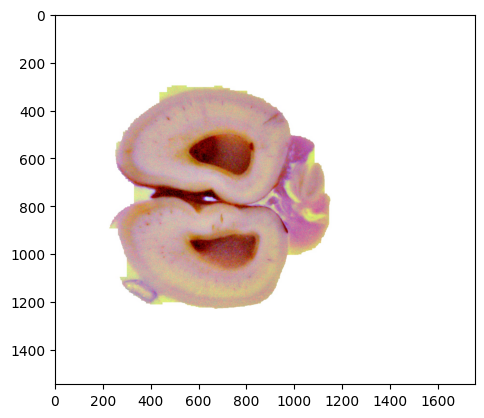

In [5]:
plt.imshow(imageio.imread(f'rf_trained_pred/retinex/{slide_id}_retinex.jpg'))

In [29]:
# # plt.imshow(, cmap='gray')
# for slide_id in tqdm(slide_stain):
#     imgs = slide_stain[slide_id]
#     # os.makedirs(f'crowd_source_ref/{slide_id}', exist_ok=True)
#     imgs = [imageio.imread(f'stain_sep_results/{slide_id}/{img}') for img in imgs]
#     for img_idx,img in enumerate(imgs):
#         new_img = cv2.cvtColor(black2white(img), cv2.COLOR_RGB2GRAY)
#         new_img = cv2.morphologyEx(new_img, cv2.MORPH_HITMISS, np.ones((3,3), np.uint8), iterations=10)
#         new_img[new_img<3]=255
#         new_img = cv2.GaussianBlur(new_img, (5,5), 1)
#         new_img = cv2.morphologyEx(new_img, cv2.MORPH_CLOSE, np.ones((3,3), np.uint8), iterations=10)
#         cv2.imwrite(f'crowd_source_ref/{slide_id}_{slide_stain[slide_id][img_idx]}', new_img)
#         # plt.imshow(new_img, cmap='gray')
#         # plt.axis('off')
#         # plt.show()

In [6]:
retinex_imgs = [cv2.imread(f'rf_trained_pred/retinex/{img}', cv2.IMREAD_GRAYSCALE) for img in tqdm(sorted(os.listdir('rf_trained_pred/retinex/'))) if regex.match(img)[0] not in ['0849','2089','1450']]
retinex_masks = [cv2.imread(f'rf_trained_pred/processed_mask/{img}', cv2.IMREAD_GRAYSCALE) for img in tqdm(sorted(os.listdir('rf_trained_pred/processed_mask/'))) if regex.match(img)[0] not in ['0849','2089','1450']]

100%|██████████| 2627/2627 [00:43<00:00, 60.13it/s]


In [7]:
def binarize_mask(mask):
    mask[mask>0] = 1
    return mask

retinex_masks = [binarize_mask(mask) for mask in tqdm(retinex_masks)]


100%|██████████| 2624/2624 [00:02<00:00, 948.89it/s] 


In [8]:
def get_percentile(slide_idx, retinex_imgs=retinex_imgs,retinex_masks=retinex_masks, p=11):
    try:
        return np.percentile(retinex_imgs[slide_idx][retinex_masks[slide_idx]==1], np.linspace(0,100,p))
    except:
        return None
    # return np.percentile(retinex_imgs[slide_idx][retinex_masks[slide_idx]==1], np.linspace(0,100,11))



100%|██████████| 2624/2624 [00:30<00:00, 85.14it/s] 


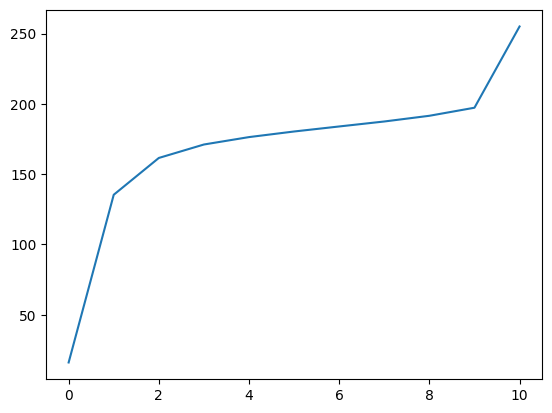

In [9]:
percentiles = [get_percentile(slide_idx) for slide_idx in tqdm(range(len(retinex_imgs)))]
percentiles = [x for x in percentiles if x is not None]
percentiles = np.array(percentiles)
percentiles = np.mean(percentiles, axis=0)
plt.plot(percentiles)

### Centroid Traversal

In [34]:
# Plot the centroids of all the images to see if they are in the same location
moments = cv2.moments(img)
centroid = (int(moments['m10']/moments['m00']), int(moments['m01']/moments['m00']))
centroid
# Plot 3d points (image index, x, y)
import plotly.graph_objs as go
import plotly.io as pio
# Sample 3D coordinates (X, Y, Z)
x_coords = [c[0] for c in centroids]
y_coords = [c[1] for c in centroids]
z_coords = list(range(len(centroids)))

# Create a 3D scatter plot
trace = go.Scatter3d(
    x=x_coords,
    y=y_coords,
    z=z_coords,
    mode='markers',
    marker=dict(
        size=5,
        color=z_coords,  # Color based on Z-axis values
        colorscale='Viridis',  # Color scale
        opacity=0.8
    )
)

# Layout for the plot
layout = go.Layout(
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    ),
    title='3D Scatter Plot'
)

# Combine trace and layout
fig = go.Figure(data=[trace], layout=layout)

# Display the plot
pio.show(fig)

NameError: name 'centroids' is not defined

In [11]:
percentiles[9]

197.23244376667938

In [12]:
os.makedirs('gray_corrected', exist_ok=True)

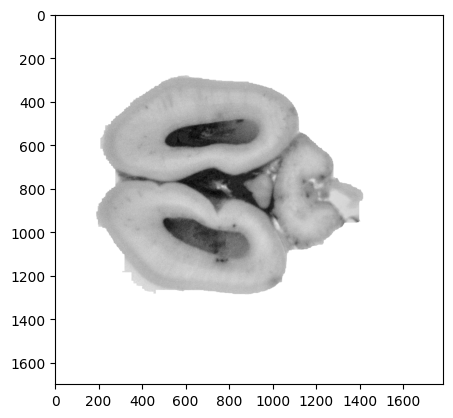

In [13]:
plt.imshow(retinex_imgs[1699], cmap='gray')

In [15]:
masks = []
for slide_idx in tqdm(range(len(retinex_imgs))):
    img = retinex_imgs[slide_idx].copy()
    # Apply the threshold
    img[img>percentiles[9]-2] = 255
    img_threshed = img.copy()
    img_threshed = cv2.GaussianBlur(img_threshed, (15,15), 1)
    img_threshed[img_threshed<255] = 0
    img_threshed = cv2.morphologyEx(img_threshed, cv2.MORPH_CLOSE, np.ones((3,3), np.uint8), iterations=5)
    contours, _ = cv2.findContours(img_threshed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = [c for c in contours if cv2.contourArea(c)<0.9*(img_threshed.shape[0]*img_threshed.shape[1])]
    mask = np.zeros_like(img)
    mask = cv2.fillPoly(mask, contours, 1)
    img = cv2.drawContours(img, contours, -1, 0, 5)
    cv2.imwrite(f'gray_corrected/{slide_idx}.jpg', img)
    # plt.imshow(mask, cmap='gray')
    masks.append(mask)

# img = cv2.morphologyEx(img, cv2.MORPH_CROSS, np.ones((3,3), np.uint8), iterations=5)
# img = cv2.GaussianBlur(img, (15,15), 1)
# img = cv2.dilate(img, np.ones((3,3), np.uint8), iterations=5)
# img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, np.ones((3,3), np.uint8), iterations=5)
# img = cv2.morphologyEx(img, cv2.MORPH_OPEN, np.ones((3,3), np.uint8), iterations=2)

100%|██████████| 2624/2624 [00:49<00:00, 52.80it/s]


In [16]:
gray_corrected = [cv2.imread(f'gray_corrected/{slide_idx}.jpg', cv2.IMREAD_GRAYSCALE) for slide_idx in tqdm(range(len(retinex_imgs)))]

100%|██████████| 2624/2624 [00:17<00:00, 151.00it/s]


#### Applying Univeral Crop to all Images

In [12]:
import scipy.ndimage as ndi

In [13]:
univ_crop_213_c = slice(1, 1584)
univ_crop_213_r = slice(172, 1382)

def apply_crop(img, r_crop, c_crop):
    return img[r_crop, c_crop]
cropped_masks = [apply_crop(mask, univ_crop_213_r, univ_crop_213_c) for mask in tqdm(masks)]
cropped_masks = [ndi.binary_fill_holes(mask) for mask in tqdm(cropped_masks)]
cropped_masks = [(255*np.ones_like(mask,dtype=np.uint8)) - mask.astype(np.uint8)*255 for mask in tqdm(cropped_masks)]


100%|██████████| 2624/2624 [00:03<00:00, 864.31it/s]


In [14]:
import ants

In [167]:
univ_crop_213_c = slice(1, 1584)
univ_crop_213_r = slice(172, 1382)

def apply_crop(img, r_crop, c_crop):
    return img[r_crop, c_crop]

cropped_masks = [apply_crop(mask, univ_crop_213_r, univ_crop_213_c) for mask in tqdm(masks)]

def ants_reg(img1, img2):
    img1 = ants.from_numpy(img1)
    img2 = ants.from_numpy(img2)
    reg = ants.registration(fixed=img1, moving=img2, type_of_transform='Rigid')
    reg_img = reg['warpedmovout']
    transform = ants.read_transform(reg['fwdtransforms'][0])
    return reg_img.numpy(), transform



100%|██████████| 2624/2624 [00:00<00:00, 1123734.30it/s]


In [15]:
import scipy.ndimage as ndi

In [16]:
os.makedirs('registered_masks', exist_ok=True)
mask_idx = 0
for mask in tqdm(cropped_masks):
    cv2.imwrite(f'registered_masks/{mask_idx}.jpg', mask)
    mask_idx+=1


100%|██████████| 2624/2624 [00:11<00:00, 229.00it/s]


In [17]:
from tqdm import trange

In [19]:
# ants.plot(ants.from_numpy(retinex_imgs[1577]), overlay=ants.from_numpy(retinex_imgs[1576]), overlay_alpha=0.5, overlay_cmap='gray')
registerred2 = []
rebb2 = []
start = ants.from_numpy(ndi.binary_fill_holes(cropped_masks[1577]).astype(np.uint8)*255)
for idx in trange(1577, 1300,-1):
    reg = ants.registration(fixed=start, moving=ants.from_numpy(ndi.binary_fill_holes(cropped_masks[idx-1]).astype(np.uint8)*255), type_of_transform='Translation')
    start = reg['warpedmovout'].numpy()
    transform = ants.read_transform(reg['fwdtransforms'][0])
    new_rebb = transform.apply_to_image(ants.from_numpy(apply_crop(retinex_imgs[idx-1], univ_crop_213_r, univ_crop_213_c))).numpy()
    rebb2.append(new_rebb)
    # start[start<=1] = 0
    registerred2.append(start)
    start = ants.from_numpy(start)
    # ants.plot(start, overlay=ants.from_numpy(new_rebb), overlay_alpha=0.5, overlay_cmap='gray')


100%|██████████| 277/277 [02:23<00:00,  1.93it/s]


In [20]:
os.makedirs(
    'fsdf', exist_ok=True
)

In [22]:
for idx, ids in enumerate(rebb2):
    cv2.imwrite(f'fsdf/{idx}.jpg', ids)

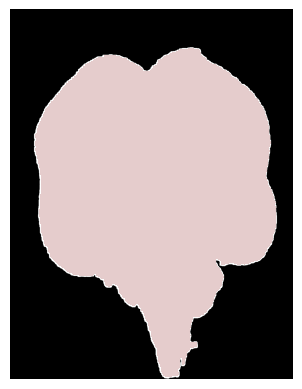

In [192]:
ants.plot(ants.from_numpy(ndi.binary_fill_holes(cropped_masks[idx-1]).astype(np.uint8)*255), overlay=ants.from_numpy(start), overlay_alpha=0.2, overlay_cmap='jet')

In [134]:
ref_idx = 1577

In [ ]:
registered_imgs = []
tranforms = []
for idx in tqdm(range(ref_idx,0,-1)):
    if idx == ref_idx:
        continue
    reg_img, transform = ants_reg(cropped_masks[idx], cropped_masks[idx-1])
    registered_img = transform.apply_to_image(ants.from_numpy(apply_crop(retinex_imgs[idx-1], univ_crop_213_r, univ_crop_213_c)))
    ants.plot(registered_img, overlay=ants.from_numpy(retinex_imgs[idx]), overlay_alpha=0.3, overlay_cmap='gray')
    break


In [143]:
os.makedirs('registered_imgs', exist_ok=True)

In [144]:
for idx, img in tqdm(enumerate(registered_imgs)):
    cv2.imwrite(f'registered_imgs/{idx}.jpg', img)

1576it [00:16, 98.47it/s] 
